In [1]:
import torch
import numpy as np
import os
from transformers import AutoModelForCausalLM, AutoConfig, set_seed
from scipy.stats import spearmanr
from safetensors import safe_open

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def get_params_safe(dir):
    # get .safetensors file
    safetensors_file = os.path.join(dir, "model.safetensors")
    with safe_open(safetensors_file, framework="pt") as f:
        params = {key: f.get_tensor(key) for key in f.keys()}

    if "qwen" in dir:
        custom_order = [
            "mlp.up_proj", "mlp.gate_proj", "mlp.down_proj",
            "self_attn.q_proj", "self_attn.k_proj", "self_attn.v_proj", "self_attn.o_proj",
            "input_layernorm", "post_attention_layernorm"
        ]
    elif "phi" in dir:
        custom_order = [
            "mlp.fc1", "mlp.fc2",
            "self_attn.q_proj", "self_attn.k_proj", "self_attn.v_proj", "self_attn.dense",
            "input_layernorm",
        ]

    def sort_key(key):
        if "lm_head" in key: return 9999, 9999
        if key == 'model.embed_tokens.weight': return -1, -1 # for Qwen
        if key == 'model.norm.weight': return 9998, 9998 # for Qwen
        if 'model.final_layernorm' in key: return 9998, 9998 # for Phi
        layer = int(key.split('.')[2])
        component = ".".join(key.split('.')[3:])
        return layer, next((i for i, c in enumerate(custom_order) if c in component), len(custom_order))

    params = dict(sorted(params.items(), key=lambda x: sort_key(x[0])))
    return params

def get_param_diff_norm(og_params, ft_params, sort=True):
    og_params = get_params_safe(og_params)
    ft_params = get_params_safe(ft_params)
    param_diff = {}
    for param_name in og_params.keys():
        diff = og_params[param_name] - ft_params[param_name]
        norm = torch.linalg.norm(diff)
        # norm = torch.abs(diff).mean()
        param_diff[param_name] = norm.item()
    param_diff = list(param_diff.items())
    if sort:
        param_diff = sorted(param_diff, key=lambda x: x[1], reverse=True)
        param_diff = [x[0] for x in param_diff]
    return param_diff

def open_params_file(path):
    with open(path, 'r') as f:
        return f.read().splitlines()

layer_colors = {
    'mlp.up_proj': 'lightsteelblue',
    'mlp.gate_proj': 'cornflowerblue',
    'mlp.down_proj': 'royalblue',

    'self_attn.q_proj': 'olivedrab',
    'self_attn.k_proj': 'limegreen',
    'self_attn.v_proj': 'darkgreen',
    'self_attn.o_proj': 'springgreen',

    'post_attention_layernorm': 'indianred',
    'input_layernorm': 'lightcoral',

    'embed_tokens': 'yellow',
    '.norm': 'magenta'
}

def categorize_layer(layer_name):
    for key in layer_colors.keys():
        if key in layer_name:
            return key

def plot_comparison(params_x, params_y, titles, in_scope=None, reverse_x=False, reverse_y=False, save=None):
    if reverse_x:
        params_x = params_x[::-1]
    if reverse_y:
        params_y = params_y[::-1]

    if in_scope:
        params_x = [p for p in params_x if any([scope in p for scope in in_scope])]
        params_y = [p for p in params_y if any([scope in p for scope in in_scope])]

    layer_categories = {layer: categorize_layer(layer) for layer in params_x}
    index_map = {p: i for i, p in enumerate(params_x)}

    original_indices = []
    modified_indices = []
    colors = []

    for v in params_y:
        original_indices.append(index_map[v])
        modified_indices.append(params_y.index(v))
        layer_category = layer_categories[v]
        colors.append(layer_colors[layer_category])

    sns.set_style('white')
    fig, ax = plt.subplots(figsize=(6, 6), dpi=300)

    scatter = ax.scatter(original_indices, modified_indices, c=colors, marker='o', edgecolor='black', s=40, alpha=0.6, label='_nolegend_')
    ideal_line, = ax.plot([0, len(params_x)-1], [0, len(params_x)-1], 'r--', lw=2, label='Perfect Order')

    ax.set_xlabel(titles[0], fontsize=16, labelpad=10)
    ax.set_ylabel(titles[1], fontsize=16, labelpad=10)
    ax.set_xlim(-1, len(params_x))
    ax.set_ylim(-1, len(params_x))
    ax.grid(True, linestyle='--', alpha=0.7)

    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.legend(handles=[ideal_line], loc='upper left', fontsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()

    spearman_corr, _ = spearmanr(original_indices, modified_indices)
    print(f"Spearman's Rank Correlation Coefficient: {spearman_corr}")

    plt.show()

    if save:
        fig.savefig(save, format='svg', bbox_inches='tight')

# Influence Ranking

In [3]:
p = get_params_safe("models/qwen2-1.5b")

In [26]:
list(p.keys())[10]

'model.layers.0.self_attn.o_proj.weight'

In [30]:
p['model.layers.0.self_attn.q_proj.weight'].shape

torch.Size([1536, 1536])

Spearman's Rank Correlation Coefficient: -0.7273019252484079


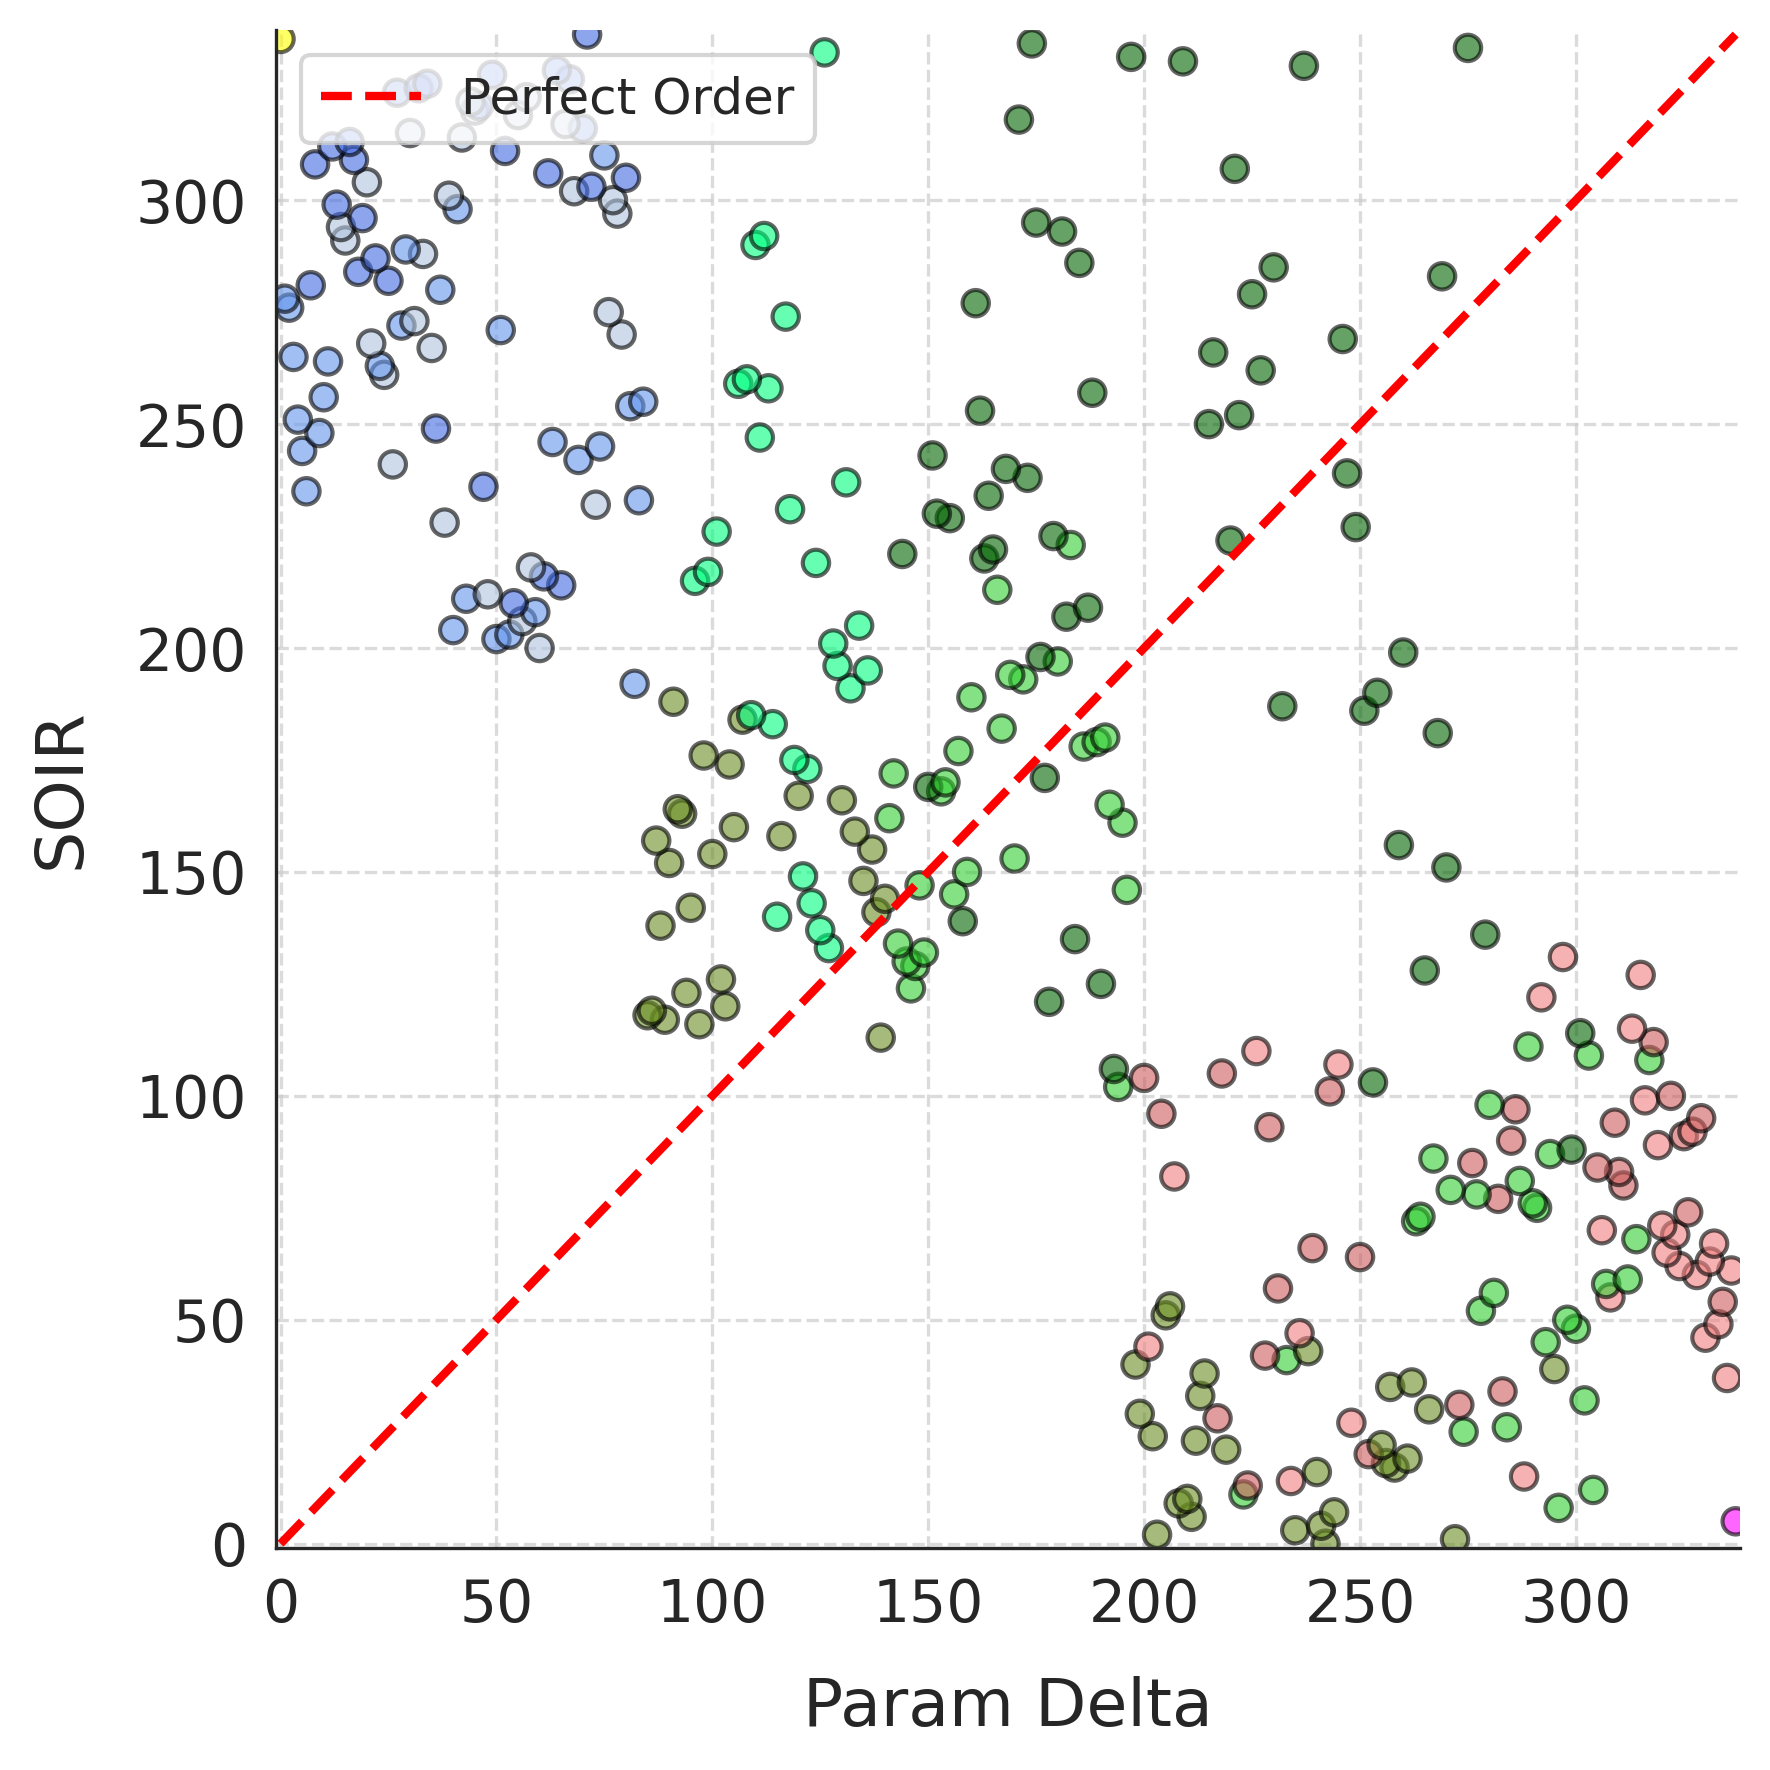

In [74]:
plot_comparison(
    params_x=get_param_diff_norm(
        "models/qwen2-1.5b",
        "models/qwen2-1.5b_ft_tofu-4000_noLORA_epochs10_lr2.5e-05_wd0.01_full_seed42/checkpoint-1250",
    ),
    params_y=open_params_file("models/qwen2-1.5b_ft_tofu-4000_noLORA_epochs10_lr2.5e-05_wd0.01_full_seed42/checkpoint-1250/so-influence_ranked_params_400r40f_4096.txt"),
    titles=["Param Delta", "SOIR"],
    in_scope=[
        "embed",
        "mlp",
        "attn",
        "norm",
    ],
    # reverse_y=True
)

Spearman's Rank Correlation Coefficient: -0.8275354822148803


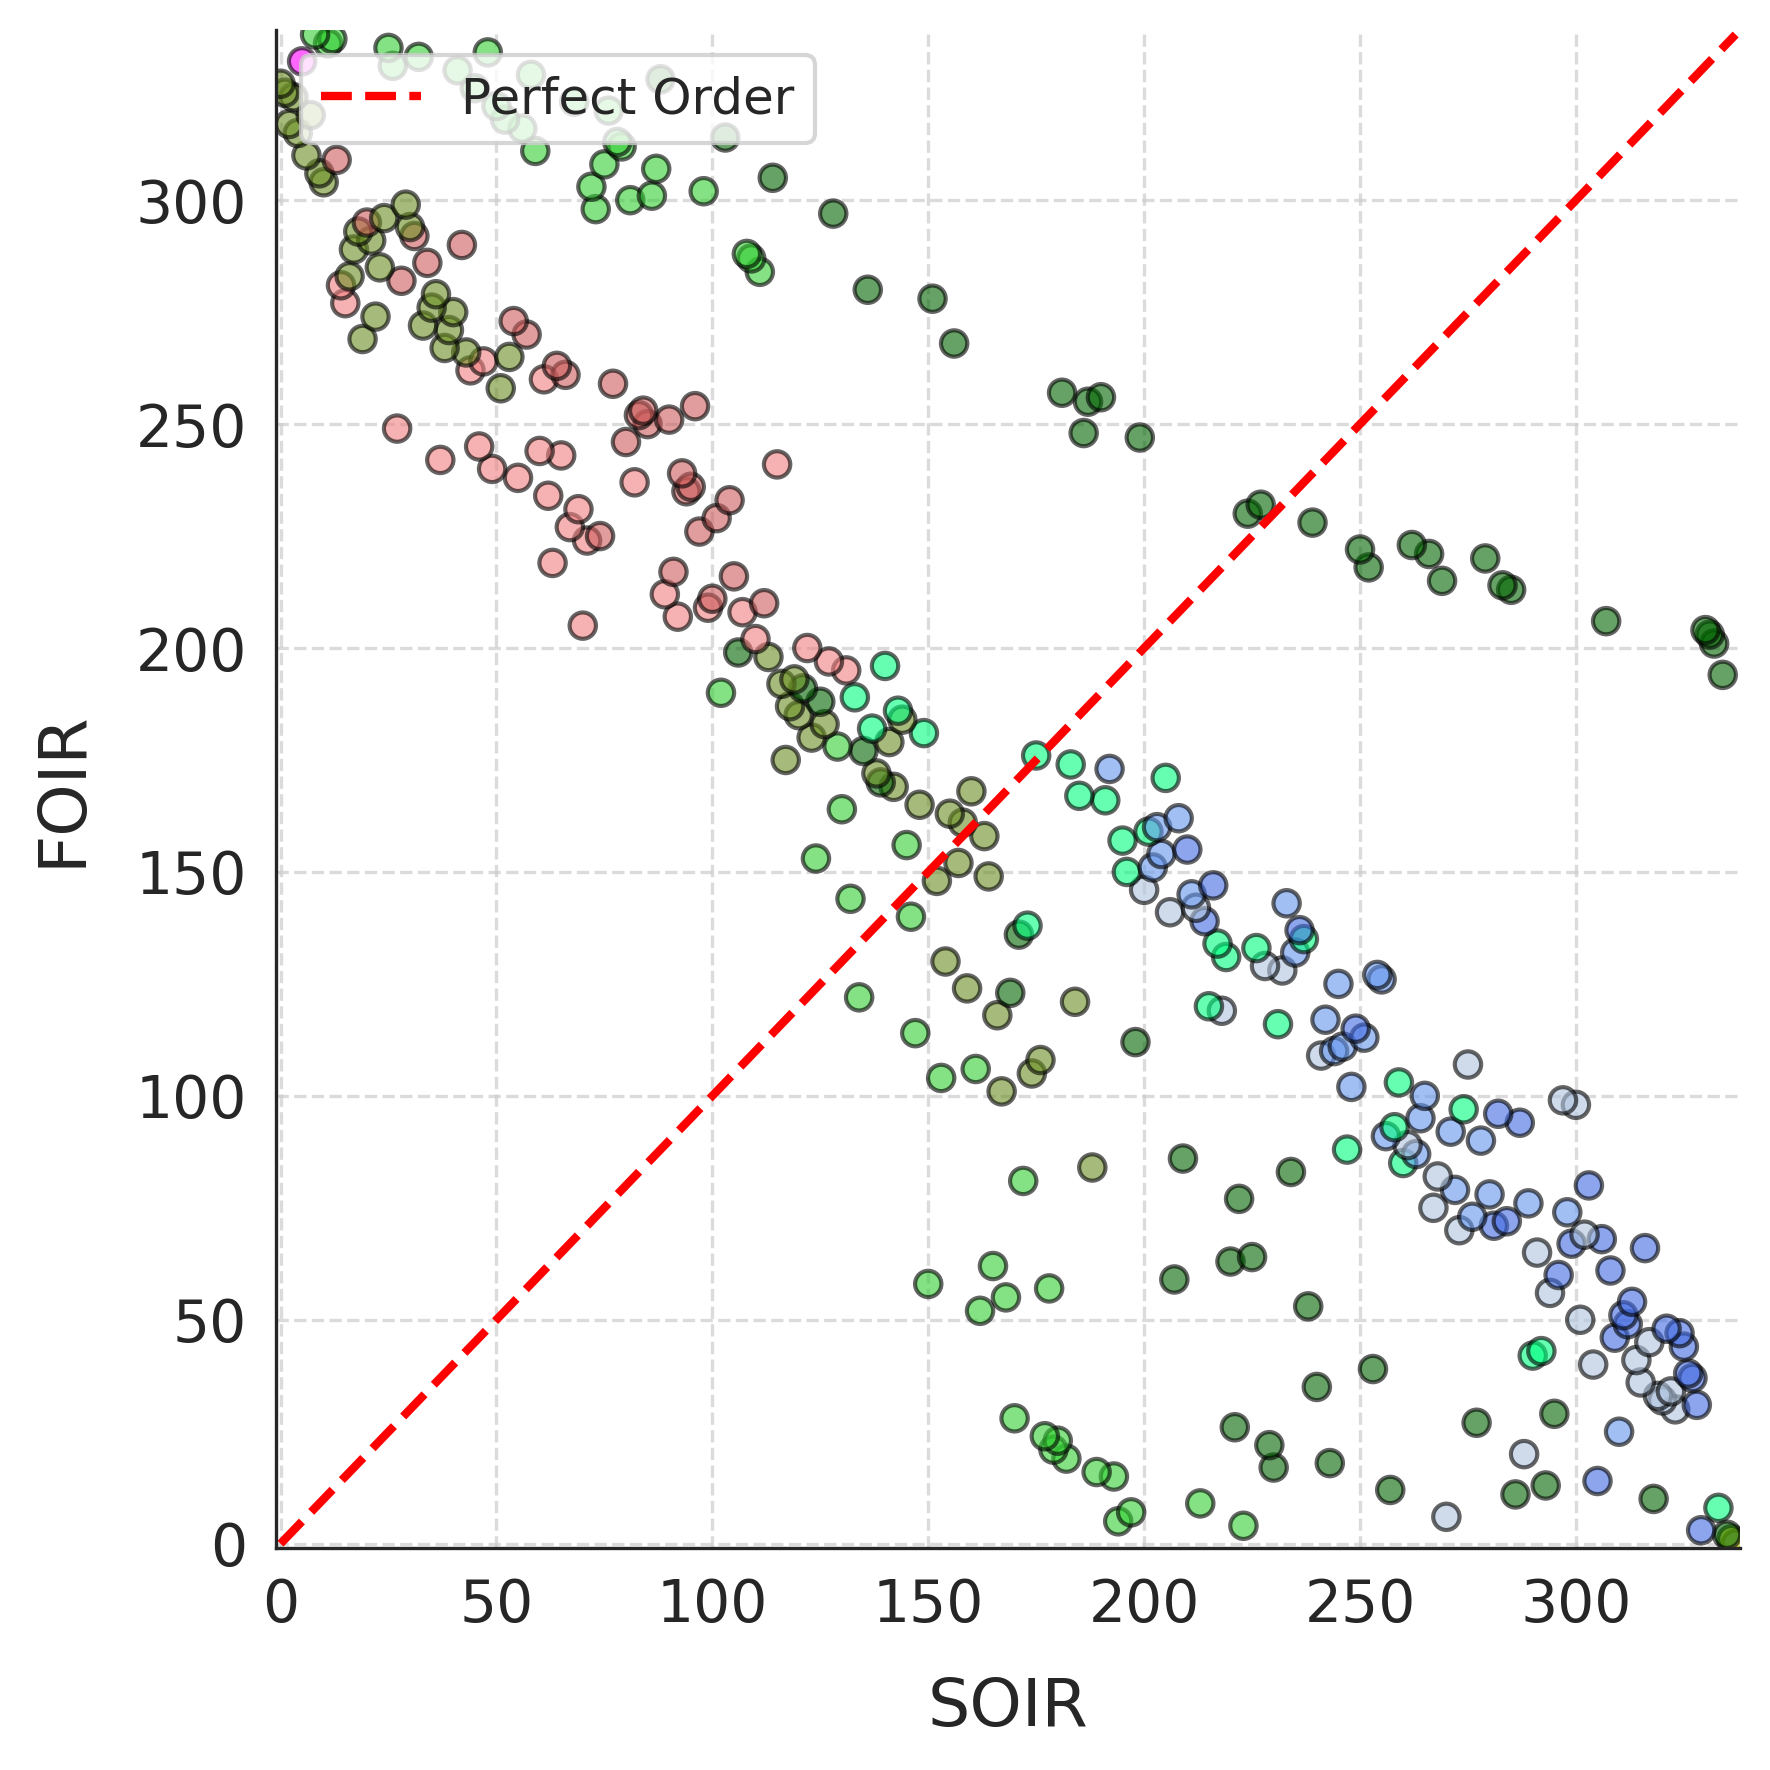

In [66]:
plot_comparison(
    params_x=open_params_file("models/qwen2-1.5b_ft_tofu-4000_noLORA_epochs10_lr2.5e-05_wd0.01_full_seed42/checkpoint-1250/so-influence_ranked_params_400r40f_4096.txt"),
    params_y=open_params_file("models/qwen2-1.5b_ft_tofu-4000_noLORA_epochs10_lr2.5e-05_wd0.01_full_seed42/checkpoint-1250/fo-influence_ranked_params_400r40f_4096.txt"),
    titles=["SOIR", "FOIR"],
    in_scope=[
        "embed",
        "mlp",
        "attn",
        "norm",
    ],
    # reverse_x=True,
)

Spearman's Rank Correlation Coefficient: -0.8699719641517794


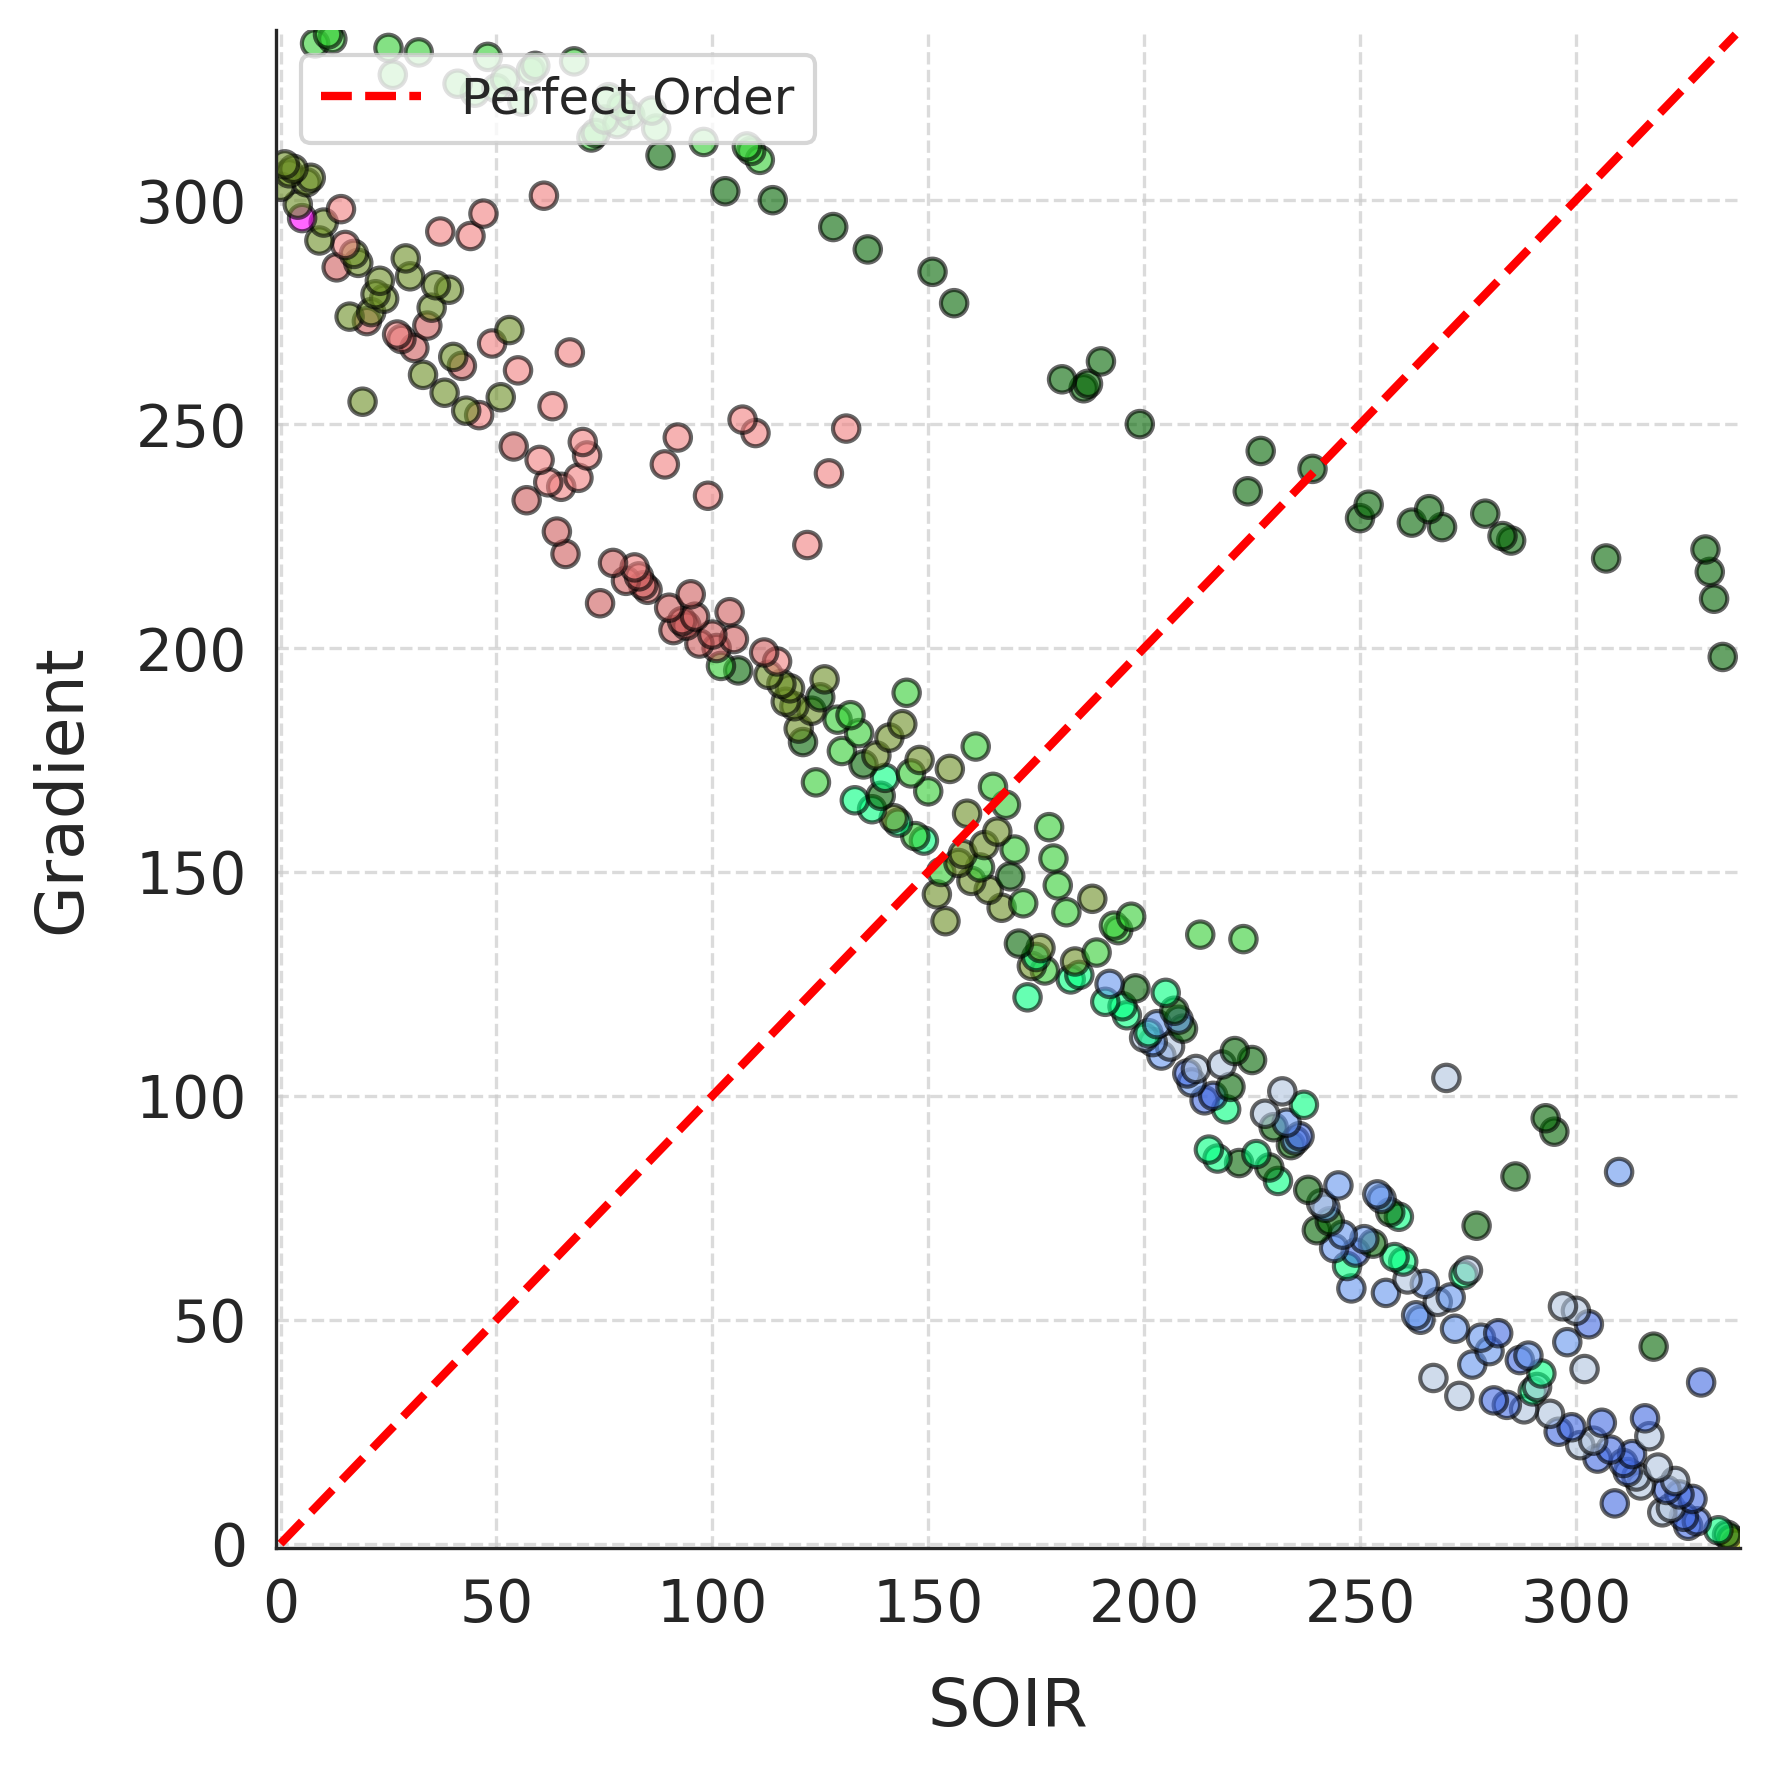

In [79]:
plot_comparison(
    params_x=open_params_file("models/qwen2-1.5b_ft_tofu-4000_noLORA_epochs10_lr2.5e-05_wd0.01_full_seed42/checkpoint-1250/so-influence_ranked_params_400r40f_4096.txt"),
    params_y=open_params_file("models/qwen2-1.5b_ft_tofu-4000_noLORA_epochs10_lr2.5e-05_wd0.01_full_seed42/checkpoint-1250/gradient_ranked_params_400r40f_4096.txt"),
    titles=["SOIR", "Gradient"],
    in_scope=[
        "embed",
        "mlp",
        "attn",
        "norm",
    ],
    # reverse_x=True,
)

Spearman's Rank Correlation Coefficient: 0.9930720704496443


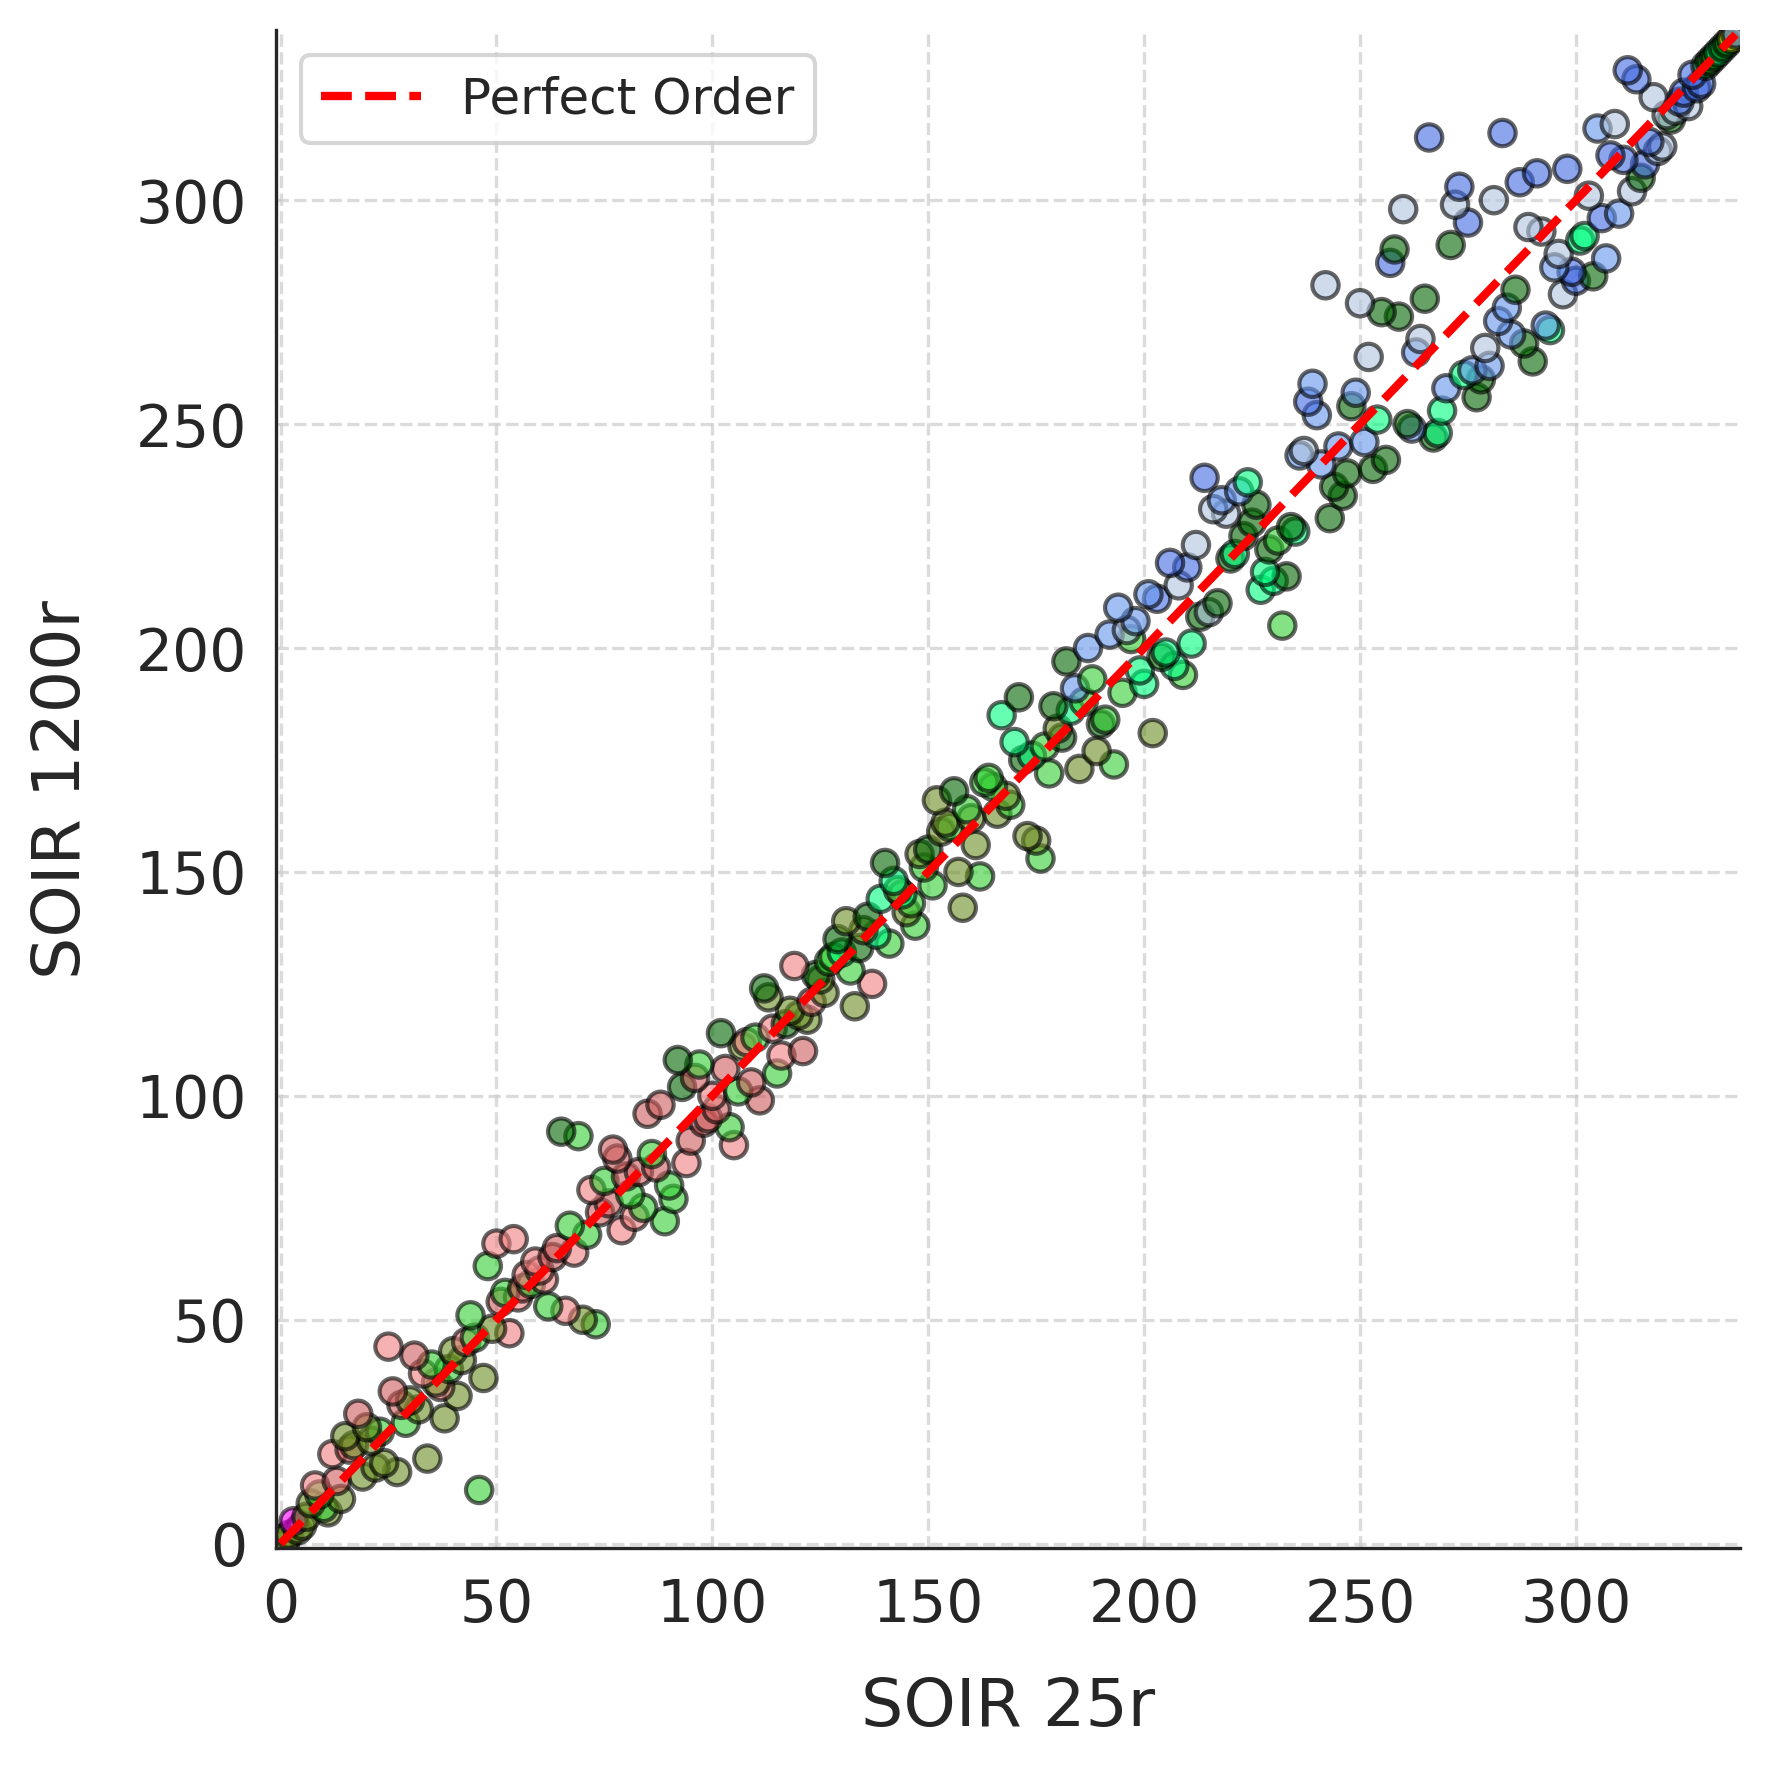

In [65]:
plot_comparison(
    params_x=open_params_file("models/qwen2-1.5b_ft_tofu-4000_noLORA_epochs10_lr2.5e-05_wd0.01_full_seed42/checkpoint-1250/so-influence_ranked_params_25r40f_4096.txt"),
    params_y=open_params_file("models/qwen2-1.5b_ft_tofu-4000_noLORA_epochs10_lr2.5e-05_wd0.01_full_seed42/checkpoint-1250/so-influence_ranked_params_1200r40f_4096.txt"),
    titles=["SOIR 25r", "SOIR 1200r"],
    in_scope=[
        "embed",
        "mlp",
        "attn",
        "norm",
    ],
    # reverse_x=True,
    # reverse_y=True,
)